In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" # set gpu number to use

from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline
from IPython.display import clear_output
import random
import itertools
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from tqdm import tqdm_notebook
from torch.nn.functional import logsigmoid
import seaborn as sns
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
api = 'GGF21Vtrnid3Cgat9n1nL9Vcc'

BATCH_SIZE = 32


In [3]:
def crop_center(pil_img):
    img_width, img_height = pil_img.size
    crop_size = img_width // 10
    return pil_img.crop(((img_width - crop_size) // 2,
                         (img_height - crop_size) // 2,
                         (img_width + crop_size) // 2,
                         (img_height + crop_size) // 2))

def load_dataset(data_path='../../../data/hazelnut/train/', batch_size=BATCH_SIZE):
    train_dataset = dset.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.RandomRotation(20, resample=Image.BILINEAR),
            transforms.CenterCrop(768),
            transforms.Resize(128),
            transforms.ColorJitter(hue=.003, saturation=.003),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
            ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader

def load_test_dataset(batch_size=BATCH_SIZE*2):
    data_path = '../../../data/hazelnut/test/'
    test_dataset = dset.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.CenterCrop(768),
            transforms.Resize(128),
            transforms.ToTensor()
            ])
    )
    print(test_dataset.class_to_idx['good'])
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        #shuffle=True,
        drop_last=True
    )
    return test_loader


def sample_noise(batch_size, dim):
    normal = torch.distributions.Normal(loc=0, scale=1)
    return normal.sample((batch_size, dim))

In [4]:
#https://discuss.pytorch.org/t/vanishing-gradients/46824/5
def plot_grad_flow(named_parameters, title):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            try:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
                
            except:
                print(n)
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title(title)
    plt.show()

In [5]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        gaussian = nn.Conv2d(..., bias=False)
        with torch.no_grad():
            gaussian.weight = gaussian_weights
        self.layer1 = nn.Sequential(
             nn.Linear(100,64*32*32),
             nn.BatchNorm1d(64*32*32),
             nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(                                
                        nn.ConvTranspose2d(64, 128, kernel_size=5),                 # 128 x 3 x 36
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(128, 256, kernel_size=7),                # 256 x 42 x 42
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU()
        )
        
        self.skip1 = nn.Sequential(
                        nn.ConvTranspose2d(64, 256, kernel_size=11), #256 x 42 x 42
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU()
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(256, 256, kernel_size=7),                # 256 x 48 x 48
                        nn.BatchNorm2d(256),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2),  # 128 x 95 x 95
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
        )
        self.skip2 = nn.Sequential(
                        nn.ConvTranspose2d(64, 128, kernel_size=4, stride=3, padding=1), #128 x 95 x 95
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(128, 128, kernel_size=11),              # 128 x 105 x 105
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(128, 64, kernel_size=11),               # 64 x 115 x 115
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 32, kernel_size=7),                 # 32 x 121 x 121
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
        )
        self.skip3 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, kernel_size=5, stride=4, padding=4),  #32 x 121 x 121
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
        )
        self.layer5 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size=7),                 # 64 x 127 x 127
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(16, 8, kernel_size=8, stride=2, padding=2),  # 8 x 256 x 256
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,8,kernel_size=7, padding=3),
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,8,kernel_size=5, padding=2),
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,8,kernel_size=3, padding=1),
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,3,kernel_size=1),                    
                        nn.Sigmoid()
        )

    def forward(self,z):
        out = self.layer1(z)
        x = out.view(out.size()[0],64,32,32)
        out = self.layer2(x) + self.skip1(x)
        out = self.layer3(out) + self.skip2(x)
        out = self.layer4(out) + 2 * self.skip3(x)
        out = self.layer5(out)
        return out

In [6]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100, 256),
             nn.BatchNorm1d(256),
             nn.ReLU()
        )
        
        self.layer2 = nn.Sequential( 
                        nn.Upsample(scale_factor=2),    #16 x 8 x 8
                        nn.Conv2d(16, 32, kernel_size=3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 16, kernel_size=5, padding=2),
                        nn.BatchNorm2d(16),
                        nn.Upsample(scale_factor=2),   
                        nn.Conv2d(16, 8, kernel_size=3, padding=1),                   # 16 x 31 x 31
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1), # 16 x 31 x 31
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 16, kernel_size=5, padding=2),                   # 16 x 31 x 31
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 16, kernel_size=7, padding=3),                   # 16 x 31 x 31
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU()
        )


        self.layer3 = nn.Sequential(
                        nn.Upsample(scale_factor=2),                                # 16 x 62 x 62                      
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(16, 32, kernel_size=3),                  # 32 x 64 x 64
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(), 
                        nn.Conv2d(32, 64, kernel_size=7, padding=3),                 # 32 x 64 x 64
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 32, kernel_size=9, padding=4),                 # 32 x 64 x 64
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 16, kernel_size=5, padding=2), 
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 3, kernel_size=1),
                        nn.Sigmoid()
        )
        
    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.shape[0],16,4,4)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [7]:
# Discriminator receives 1x28x28 image and returns a float number
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 8, kernel_size=7,stride=2,padding=3),  # 3 x 64 x 64
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(8, 16, kernel_size=7, stride=4, padding=3),  # batch x 16 x 8 x 8
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU()
        )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16, 1, kernel_size=5), #batch x 1 x 4 x 4
                        nn.LeakyReLU()
            
        )
        self.fc = nn.Sequential(
                        nn.Linear(4 * 4, 1)
        )
        


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        feature = out.view(out.shape[0], -1)
        #out = out.view(out.shape[0], 16, 8, 8)
        out = self.layer3(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out,feature

In [8]:
from torchsummary import summary

generator = Generator().to(device)
discriminator = Discriminator().to(device)

summary(generator, (100, ))
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
       BatchNorm1d-2                  [-1, 256]             512
              ReLU-3                  [-1, 256]               0
          Upsample-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
       BatchNorm2d-6             [-1, 32, 8, 8]              64
         LeakyReLU-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 16, 8, 8]          12,816
       BatchNorm2d-9             [-1, 16, 8, 8]              32
         Upsample-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,160
      BatchNorm2d-12            [-1, 8, 16, 16]              16
        LeakyReLU-13            [-1, 8, 16, 16]               0
  ConvTranspose2d-14           [-1, 16,

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.RMSprop(generator.parameters(), lr=1e-3)
gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_opt, 0.96)
disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)
disc_scheduler = torch.optim.lr_scheduler.ExponentialLR(disc_opt, 0.96)

In [14]:
train_loader = iter(load_dataset())

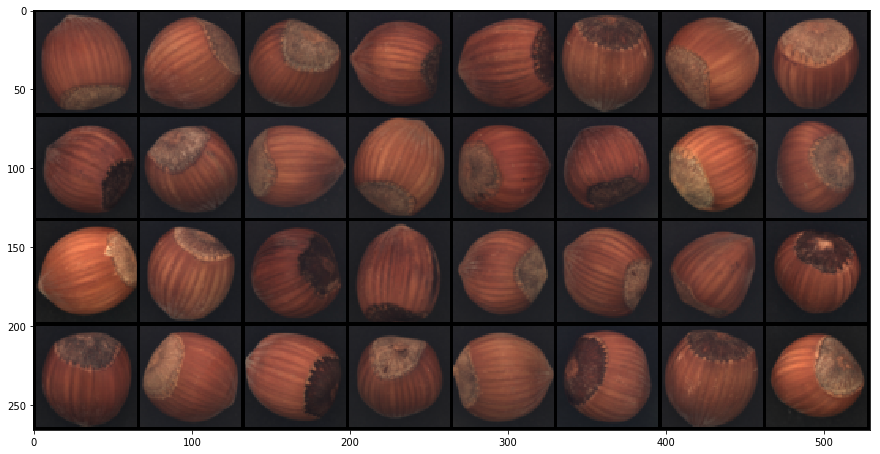

In [21]:
plt.figure(figsize = (15,10))
plt.imshow(v_utils.make_grid(next(train_loader)[0].data[:32]).cpu().detach().permute(1, 2, 0).numpy());

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(256, 512),
             nn.BatchNorm1d(512),
             nn.ReLU()
        )
        
        self.layer2 = nn.Sequential( 
                        nn.Upsample(scale_factor=2, mode='bilinear'),   
                        nn.Conv2d(8, 8, kernel_size=3, padding=1),                  # 16 x 16 x 16
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU(),
                        nn.Upsample(scale_factor=2, mode='bilinear'),               # 16 x 32 x 32
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU(),
                        nn.Conv2d(8, 16, kernel_size=5, padding=2),                # 16 x 32 x 32
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 16, kernel_size=7, padding=3),                # 16 x 32 x 32
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU()
        )


        self.layer3 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear'),             # 16 x 62 x 62                      
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 32, kernel_size=7, padding=3),                 # 32 x 64 x 64
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 32, kernel_size=9, padding=4),                 # 32 x 64 x 64
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear'),               # 32 x 128 x 128
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 16, kernel_size=7, padding=3), 
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 8, kernel_size=5, padding=2), 
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8, 3, kernel_size=1),
                        nn.Sigmoid()
            
        )


    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.shape[0],8,8,8)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 8, kernel_size=7,stride=2,padding=3), 
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(kernel_size=2) #batch x 64 x 32 x 32
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(8, 16, kernel_size=7, stride=4, padding=3),  # batch x 16 x 8 x 8
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU()
        )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16, 1, kernel_size=5), #batch x 1 x 4 x 4
                        nn.LeakyReLU()
            
        )
        self.fc = nn.Sequential(
                        nn.Linear(4 * 4, 1)
        )
        


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        feature = out.view(out.shape[0], -1)
        out = out.view(out.shape[0], 16, 8, 8)
        out = self.layer3(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out,feature

In [27]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(torch.load('./models/generator_anogans_continued_128.ckpt'))
discriminator.load_state_dict(torch.load('./models/discriminator_anogans_continued_128.ckpt'))

<All keys matched successfully>

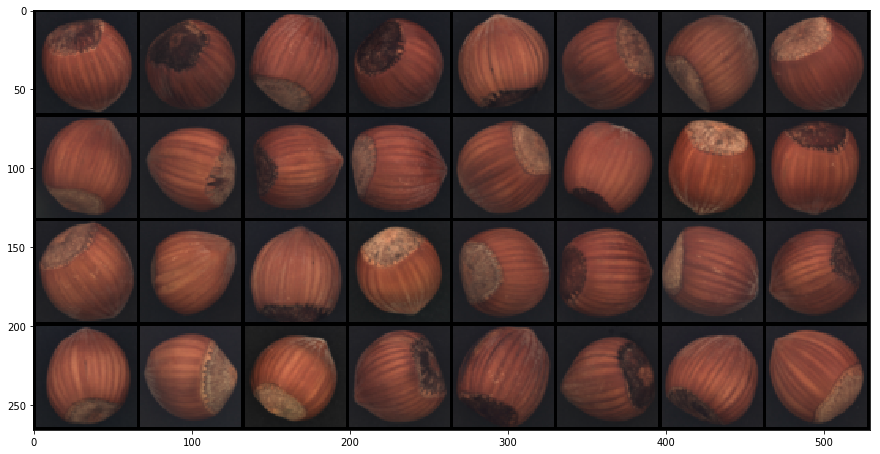

In [76]:
plt.figure(figsize = (15,10))
plt.imshow(v_utils.make_grid(next(train_loader)[0].data[:32]).cpu().detach().permute(1, 2, 0).numpy());

In [11]:
def train_n_test_GP(epochs, lmbd=10):
    experiment = Experiment(api_key=api, project_name="GAN nuts", workspace="comet-ml testing")
    k, m = 5, 1
    with experiment.train():
        generator.train()
        discriminator.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = iter(load_dataset())
            for i in range(len(train_loader) // k):
                for _ in range(k):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(train_loader)
                    real_data = real_data.to(device)
                    t = torch.rand(BATCH_SIZE, 1, 1, 1).to(device)
                    t = t.expand(gen_data.size()) #?
                    in_between = t * real_data + (1 - t) * gen_data
                    disc_in_between, _ = discriminator(in_between)
                    gradients = torch.autograd.grad(outputs=disc_in_between, inputs=in_between,
                                      grad_outputs=torch.ones(disc_in_between.size()).to(device),
                                      create_graph=True, retain_graph=True, only_inputs=True)[0]
                    gradients = gradients.view(gradients.size(0), -1)
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)
                    
                    disc_loss = disc_fake.mean() - disc_real.mean() +\
                            ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lmbd

                    experiment.log_metric("discriminator loss", disc_loss.item())
                    disc_loss.backward()
                    disc_opt.step()
                for _ in range(m):
                    gen_opt.zero_grad() 
                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().permute(1, 2, 0).numpy())
                        experiment.log_figure()
                        plt.title("epoch: {0}, iteration: {1}".format(epoch, i))
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -disc.mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
#                     plot_grad_flow(generator.named_parameters(), 'generator')
                    gen_opt.step()
            gen_scheduler.step() 
            disc_scheduler.step() 
            if epoch % 50 == 0:
                torch.save(generator.state_dict(), './models/generator_64_{}.ckpt'.format(epoch))
                torch.save(discriminator.state_dict(), './models/discriminator_64_{}.ckpt'.format(epoch))           
        experiment.end() 

In [ ]:
train_n_test_GP(200)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/gan-nuts/fdff6090daf14e66b51d058c49d37ef4



In [13]:
torch.save(generator.state_dict(), './models/generator_gan_nuts_64.ckpt')
torch.save(discriminator.state_dict(), './models/discriminator_gan_nuts_64.ckpt')   

In [8]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    _, d1 = discriminator(x)
    _, d2 = discriminator(G_z)
    feature_dist = (d1 - d2).norm(2, dim=1)
    image_dist = (x - G_z).norm(2, dim=1)
    return image_dist.view(image_dist.shape[0], -1).mean(axis=1)**2 + Lambda * feature_dist ** 2

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=7, padding=3),   # batch x 32 x 128 x 128
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(32, 64, kernel_size=5, padding=2),   # batch x 32 x 128 x 128
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(64, 32, kernel_size=5, padding=2),   # batch x 32 x 64 x 64
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),  # batch x 32 x 32 x 32
                        nn.Conv2d(32, 32, kernel_size=7, padding=3),   # batch x 32 x 32 x 32
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 16, kernel_size=5),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Conv2d(16, 16, kernel_size=7,padding=3),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16,32,kernel_size=5,padding=2),  # batch x 32 x 14 x 14
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(32, 16, kernel_size=3,padding=1),  # batch x 16 x 14 x 14
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16, 8, kernel_size=3,padding=1), #batch x 8 x 7 x 7 
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(8 * 7 * 7, 256)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [28]:
def train_izi(epochs, encoder, f=False):
    BATCH_SIZE = 256
    lmbd = 1
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    encoder.eval()
    with experiment.train():
        encoder.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = load_dataset()
            for i, (img, _) in enumerate(train_loader):
                izi_opt.zero_grad()
                z = encoder(img.to(device))
                gen_data = generator(z.to(device))
                _, real_features = discriminator(img.to(device))
                _, gen_features = discriminator(gen_data)
                feature_dist = (real_features - gen_features).norm(2, dim=1).cpu()
                feature_dist.view(feature_dist.shape[0], -1)
                image_dist = (img - gen_data.cpu()).norm(2, dim=1).mean(axis = [1,2])
                image_dist.view(image_dist.shape[0], -1)
                loss = image_dist.mean()**2
                if f:
                    loss += lmbd * feature_dist.mean()**2
                loss.backward()
                izi_opt.step()
    experiment.end() 
        

In [29]:
#encoder_izi = Encoder().to(device)
izi_opt = torch.optim.Adam(encoder_izi.parameters())
train_izi(15, encoder_izi)
torch.save(encoder_izi.state_dict(), './models/izi_encoder_nuts_64.ckpt')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/mnist-gan/417d6bcbee374a18a626883921b7e5e0



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/417d6bcbee374a18a626883921b7e5e0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory               : (5751177216.0, 5751177216.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (98.0, 98.0)
COMET INFO:     sys.gpu.0.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory               : (6244401152.0, 6244401152.0)
COMET INFO:     sys.gpu.1.free_memory               : (732037120.0, 732037120.0)
COMET INFO:     sys.gpu.1.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory               : (11263541248.0, 11263541248.0)
COMET INFO:     sys.gpu.2.free_memory               : (8301445120.0, 8301445120.0)
COMET INFO:     sys.gpu.2.gpu_utiliza

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [34]:
encoder_izi = Encoder().to(device)
encoder_izi.load_state_dict(torch.load('./models/izi_encoder_nuts_64.ckpt'))
encoder_izi_f = Encoder().to(device)
encoder_izi_f.load_state_dict(torch.load('./models/izi_f_encoder_nuts_64.ckpt'))

<All keys matched successfully>

In [33]:
#encoder_izi_f = Encoder().to(device)
izi_opt = torch.optim.Adam(encoder_izi_f.parameters())
train_izi(15, encoder_izi_f, f=True)
torch.save(encoder_izi_f.state_dict(), './models/izi_f_encoder_nuts_64.ckpt')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/mnist-gan/e6b2e9b3989b492d8f732480b7197cba



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/e6b2e9b3989b492d8f732480b7197cba
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory               : (5751177216.0, 5751177216.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory               : (6244401152.0, 6244401152.0)
COMET INFO:     sys.gpu.1.free_memory               : (732037120.0, 732037120.0)
COMET INFO:     sys.gpu.1.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory               : (11263541248.0, 11263541248.0)
COMET INFO:     sys.gpu.2.free_memory               : (8301445120.0, 8301445120.0)
COMET INFO:     sys.gpu.2.gpu_utilizati

In [25]:
def show_image(ax, title, img, dim=256):
    img = img.permute(1, 2, 0).numpy()
    ax.imshow(img.reshape(dim, dim, 3))
    ax.set_title(title)
    ax.axis('off')

In [107]:
print(len(load_test_dataset(8)))


2
13


In [23]:
def plot_results(loader, title, encoder, batch_size, dim=256):
    encoder.eval()
    ds = iter(loader(batch_size))
    size = min(len(ds), 10)
    fig, axes = plt.subplots(10, 4, figsize=(18, 36), gridspec_kw={'wspace':0.1, 'hspace':0.3},
                               squeeze=True)

    fig.suptitle(title, fontsize=35, y=0.91)
    for i in range(size):
        img, lbl = next(ds)
        idx = np.random.randint(0, batch_size - 2)
        ax = axes[i]
        real = img[idx : idx + 2]
        zs = encoder(real.to(device)).view(2, -1)
        real = real.cpu().detach()
        fake = generator(zs.to(device)).cpu().detach()
        r1, r2 = real[0], real[1]
        f1, f2 = fake[0], fake[1]
        lbls, imgs = ['real', 'fake', 'real', 'fake'], [r1, f1, r2, f2]
        for j in range(4):
            show_image(ax[j], lbls[j], imgs[j], dim)

2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


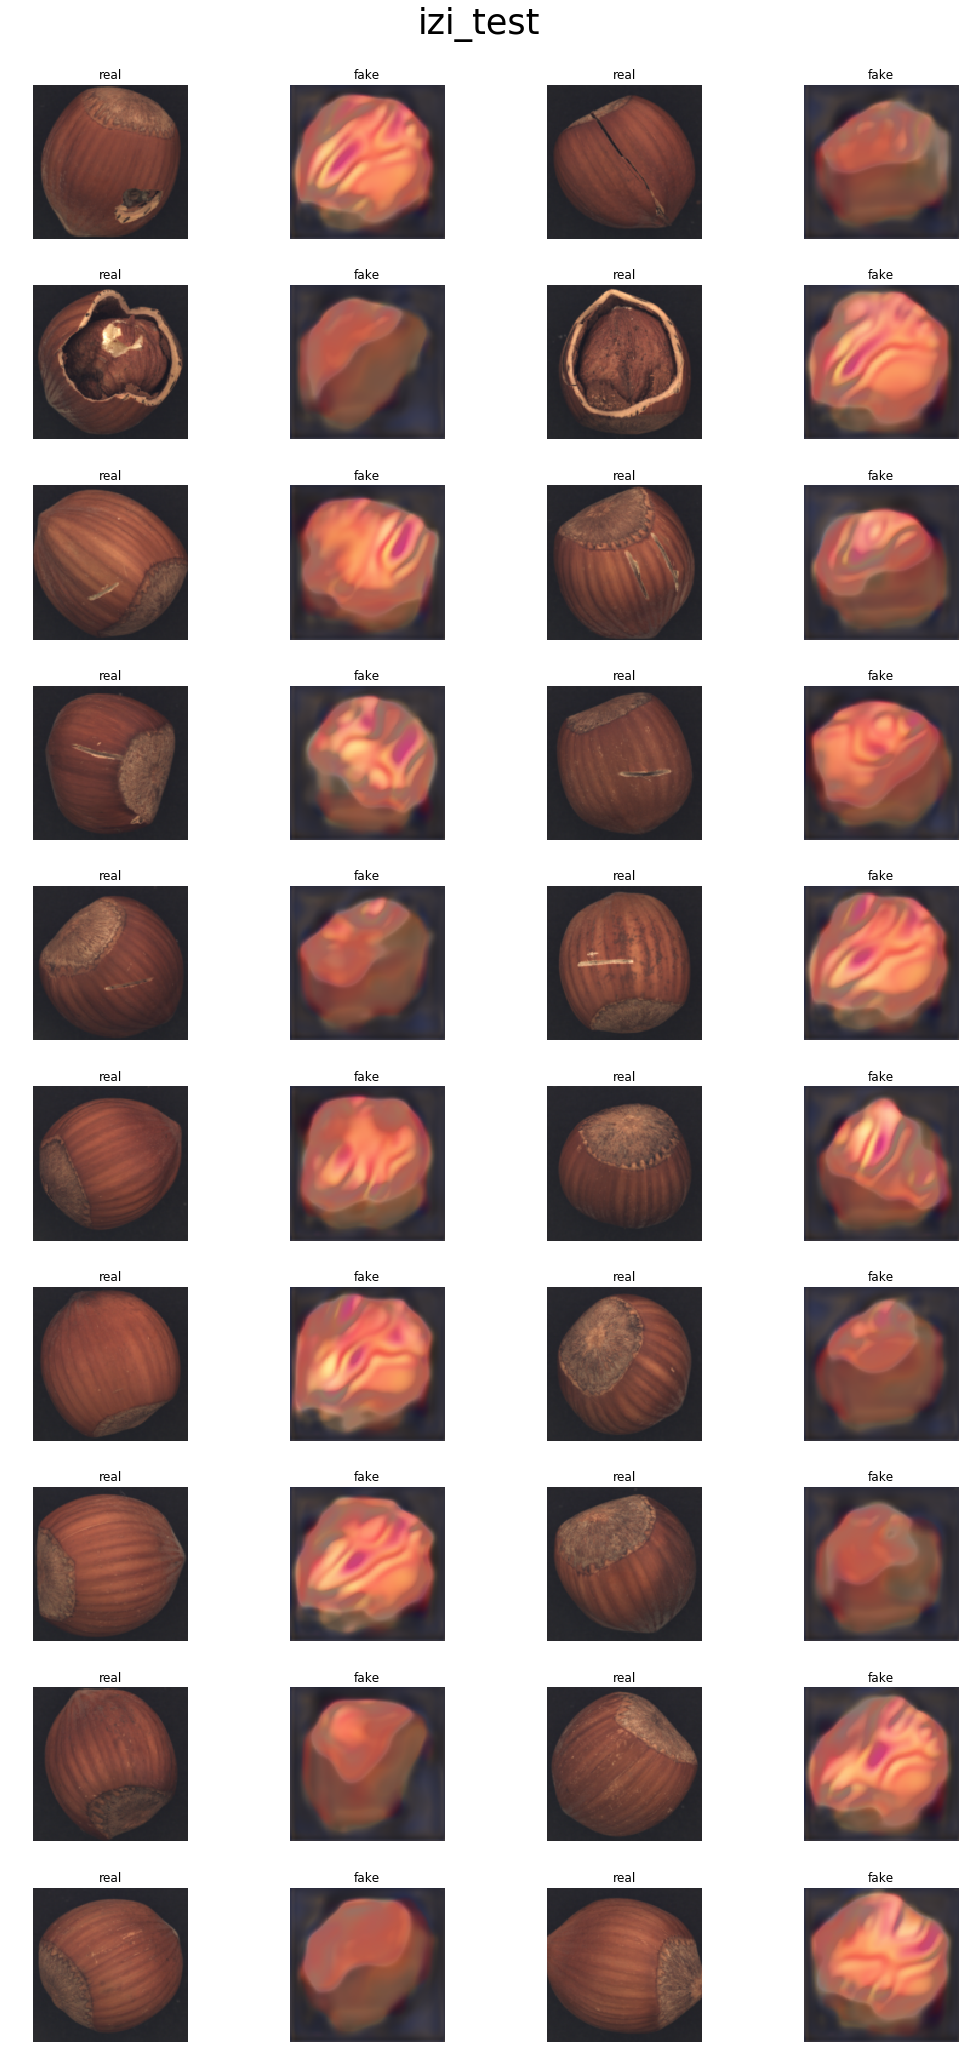

In [14]:
plot_results(load_test_dataset, 'izi_test', encoder_izi, 8, 128)

2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


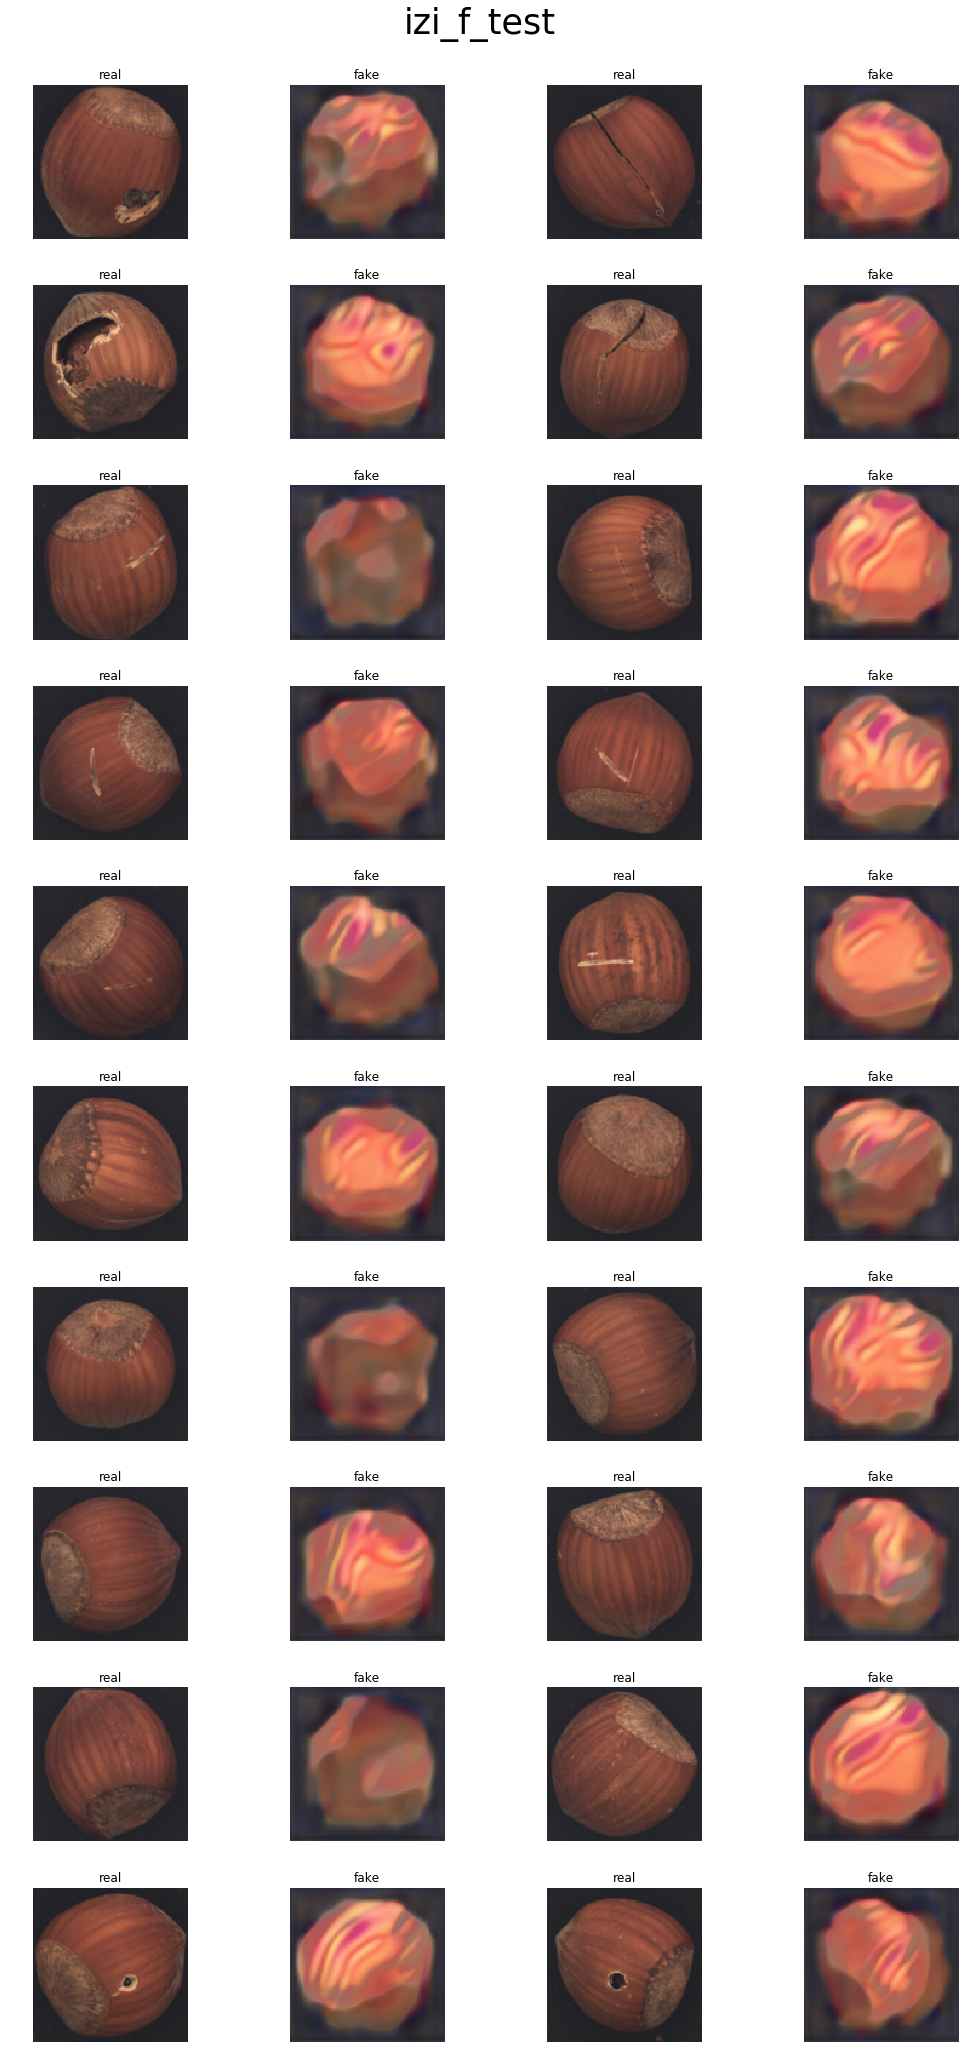

In [21]:
plot_results(load_test_dataset, 'izi_f_test', encoder_izi_f, 8, 128)

2


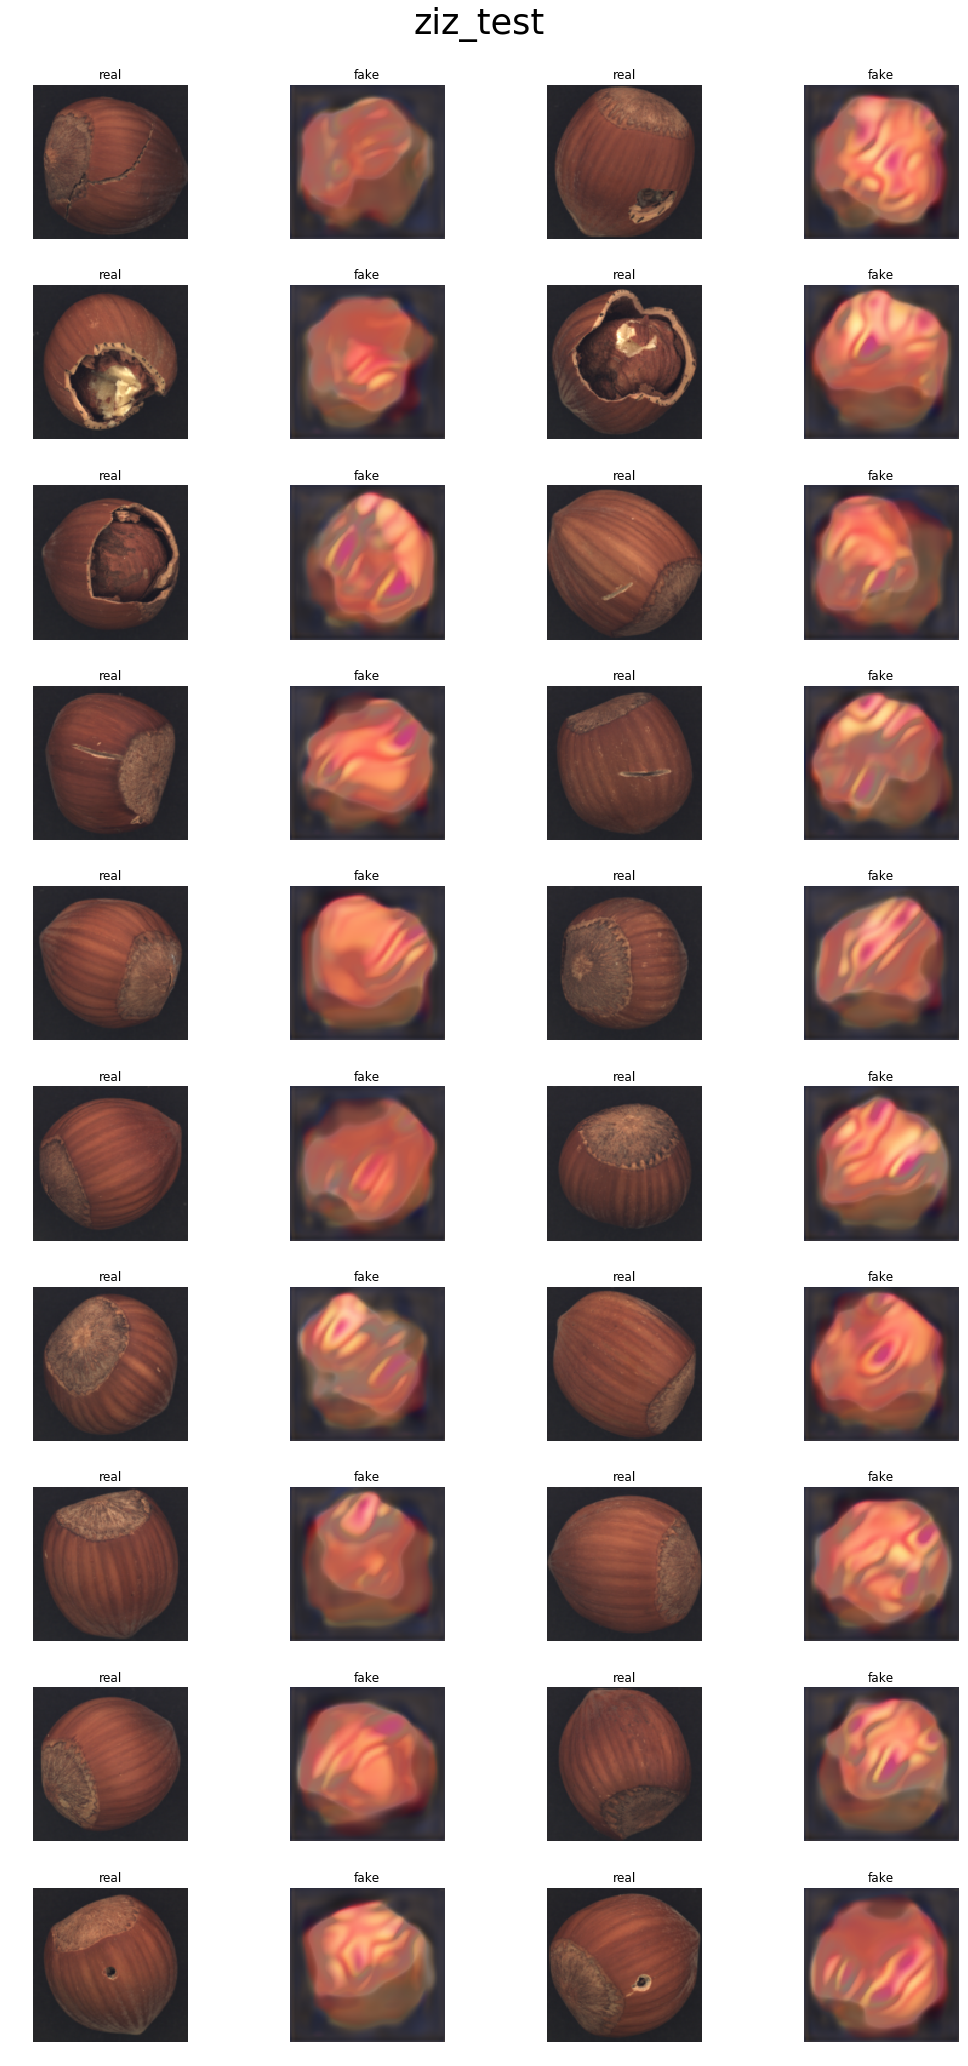

In [26]:
plot_results(load_test_dataset, 'ziz_test', encoder_ziz, 8, 128)

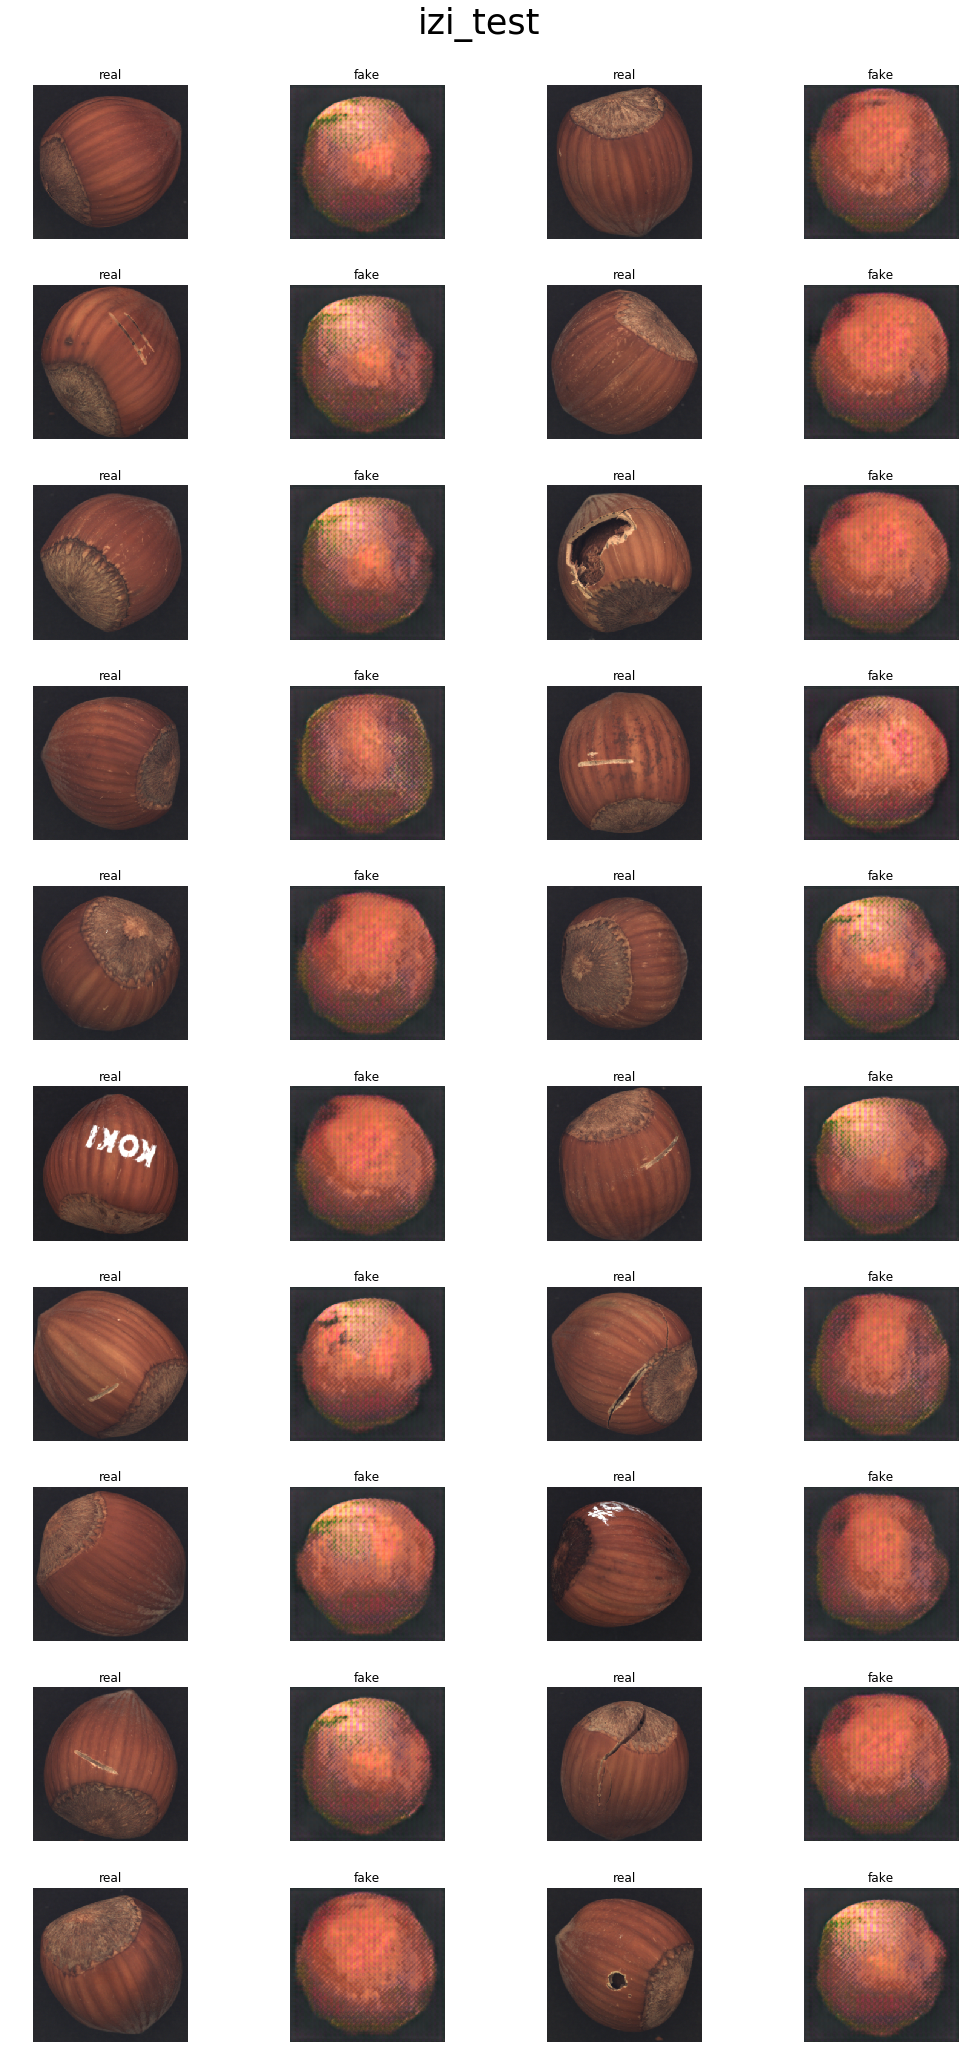

In [104]:
plot_results(load_test_dataset, 'izi_test', encoder_izi, BATCH_SIZE * 2)

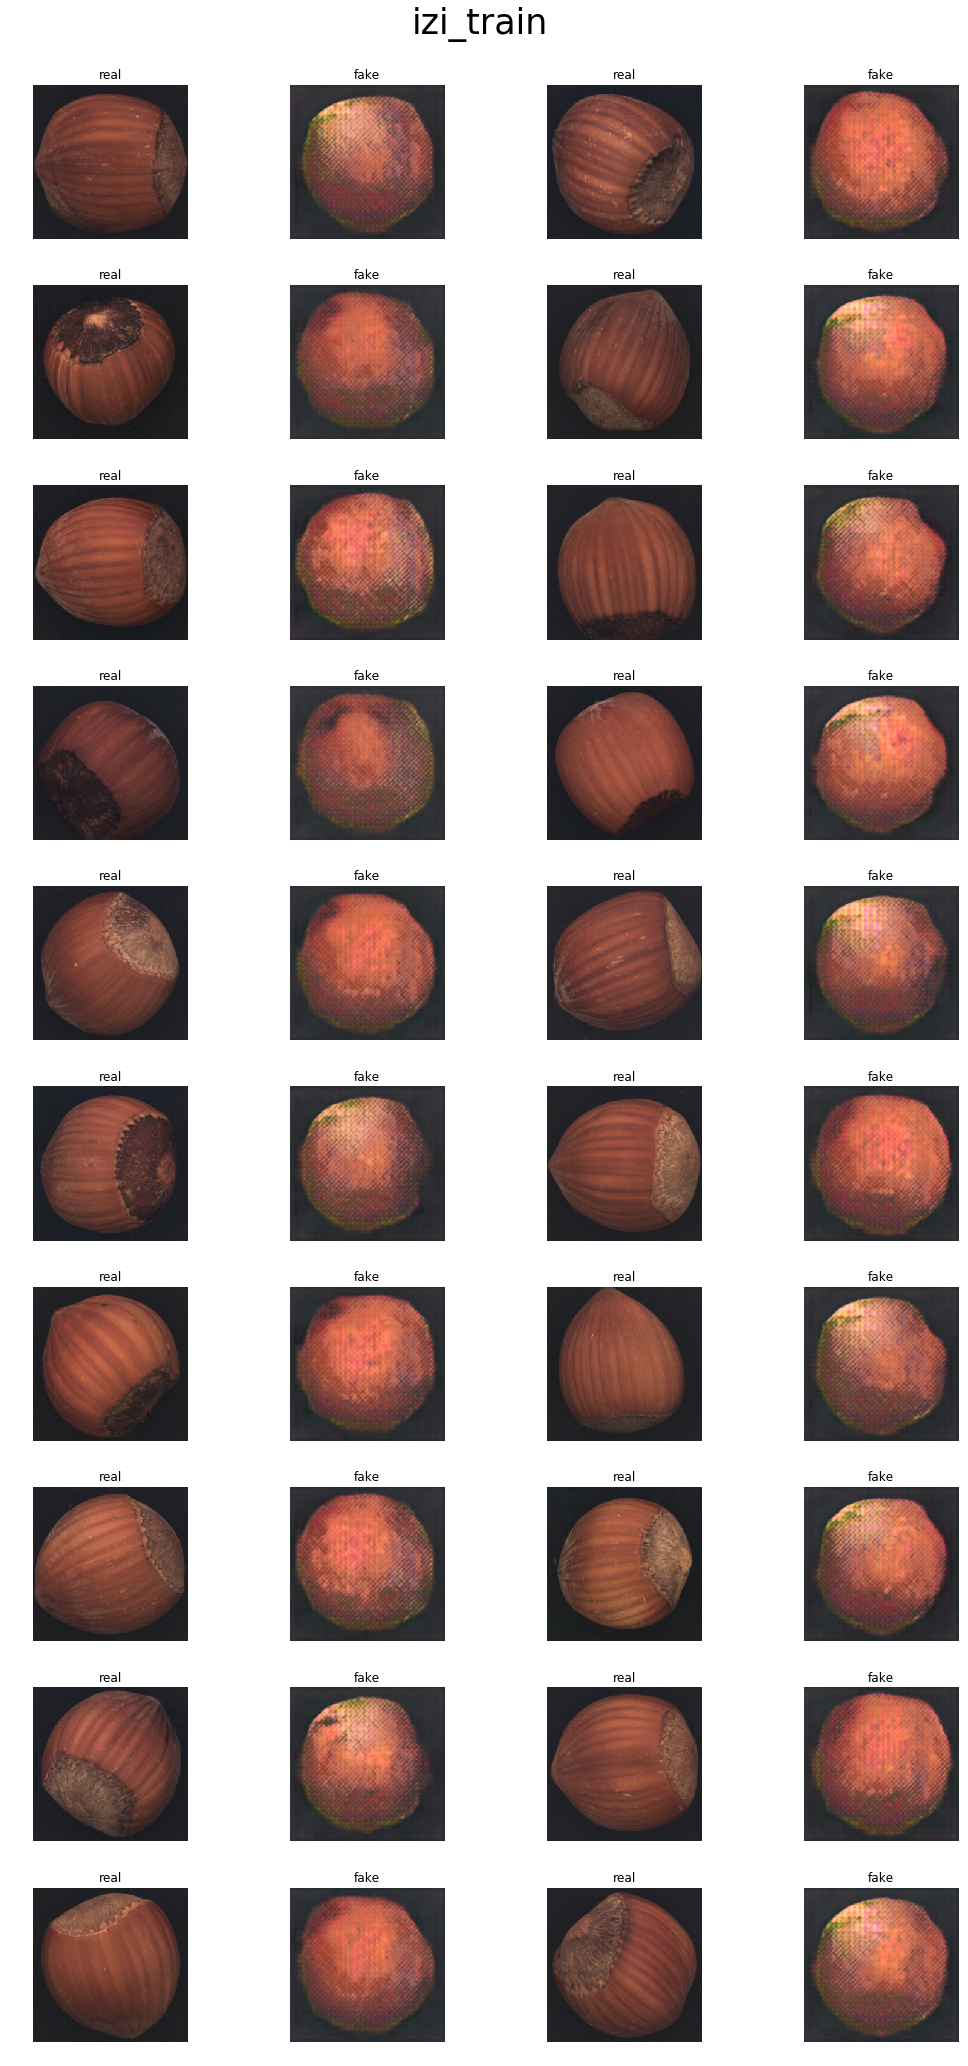

In [86]:
plot_results(load_dataset, 'izi_train', encoder_izi, BATCH_SIZE)

In [9]:
def check_anogan(title, encoder):
    encoder.train()
    good_idx = 2
    test_loader = load_test_dataset()
    big_loss, labels = np.array([]), np.array([])
    for (img, label) in test_loader:
        z = encoder(img.to(device))
        gen_fake = generator(z.to(device))
        loss = Anomaly_score(Variable(img).to(device), gen_fake, 10)
        if big_loss.size == 0:
            big_loss = loss.view(loss.shape[0]).cpu().detach().numpy()
            labels = (label != good_idx)
        else:
            big_loss = np.hstack((big_loss, loss.view(loss.shape[0]).cpu().detach().numpy()))
            labels = np.hstack((labels, (label != good_idx)))
    roc_auc = roc_auc_score(labels, big_loss)
    print('roc_auc:', roc_auc)
    sns.distplot(big_loss[labels], label='anomalies')
    sns.distplot(big_loss[~labels], label='non-anomalies')
    plt.xlabel('distance')
    plt.title(title)
    plt.legend()

2
roc_auc: 0.6748768472906405


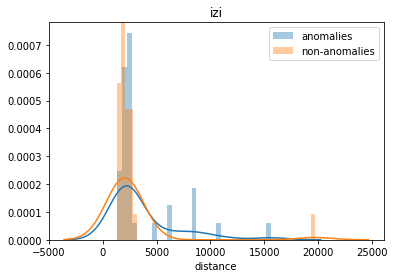

In [35]:
check_anogan('izi', encoder_izi)

2
roc_auc: 0.761576354679803


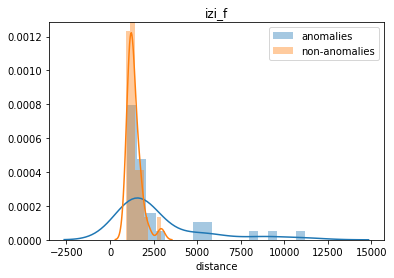

In [36]:
check_anogan('izi_f', encoder_izi_f)

In [10]:
def train_ziz(epochs, encoder, opt, f=False):
    BATCH_SIZE = 36
    lmbd = 1
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    with experiment.train():
        encoder.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = load_dataset()
            for i in range(100):
                opt.zero_grad()
                z = sample_noise(BATCH_SIZE, 256)
                gen_data = generator(z.to(device))
                encoded = encoder(gen_data).cpu()
                loss = (z - encoded).norm(2, dim=1).mean()**2
                loss.backward()
                opt.step()
    experiment.end() 
    
    
def train_izi(epochs, encoder, f=False):
    BATCH_SIZE = 256
    lmbd = 1
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    encoder.eval()
    with experiment.train():
        encoder.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = load_dataset()
            for i, (img, _) in enumerate(train_loader):
                izi_opt.zero_grad()
                z = encoder(img.to(device))
                gen_data = generator(z.to(device))
                _, real_features = discriminator(img.to(device))
                _, gen_features = discriminator(gen_data)
                feature_dist = (real_features - gen_features).norm(2, dim=1).cpu()
                feature_dist.view(feature_dist.shape[0], -1)
                image_dist = (img - gen_data.cpu()).norm(2, dim=1).mean(axis = [1,2])
                image_dist.view(image_dist.shape[0], -1)
                loss = image_dist.mean()**2
                if f:
                    loss += lmbd * feature_dist.mean()**2
                loss.backward()
                izi_opt.step()
    experiment.end() 
        
        

In [31]:
#encoder_ziz = Encoder().to(device)
ziz_opt = torch.optim.Adam(encoder_ziz.parameters())
train_ziz(15, encoder_ziz, ziz_opt)
torch.save(encoder_ziz.state_dict(), './models/ziz_encoder_nuts_64.ckpt')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/mnist-gan/a8f707a2297441ceb73279abab843fba



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/a8f707a2297441ceb73279abab843fba
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory               : (5751177216.0, 5751177216.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (98.0, 98.0)
COMET INFO:     sys.gpu.0.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory               : (6244401152.0, 6244401152.0)
COMET INFO:     sys.gpu.1.free_memory               : (732037120.0, 732037120.0)
COMET INFO:     sys.gpu.1.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory               : (11263541248.0, 11263541248.0)
COMET INFO:     sys.gpu.2.free_memory               : (8301445120.0, 8301445120.0)
COMET INFO:     sys.gpu.2.gpu_utiliza

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


2
roc_auc: 0.574384236453202


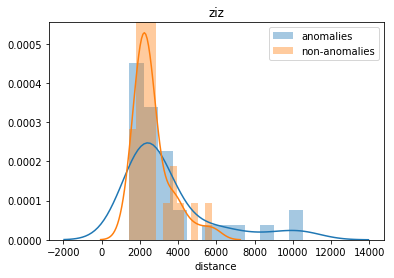

In [38]:
check_anogan('ziz', encoder_ziz)

In [ ]:
0